In [1]:
import glob
import random

from keyrover.datasets.mutliclass_image import MulticlassKeyboardImage
from keyrover import *

2024-11-05 13:43:10.713 Python[27043:6975933] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


datasets/raw/masks/keyboard_122_2.png


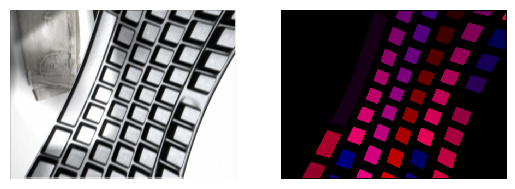

In [2]:
paths = glob.glob(f"{RAW_MASKS}/*.png")
mask_path = random.choice(paths)
print(mask_path)    
        
img = MulticlassKeyboardImage(mask_path)
img.show()

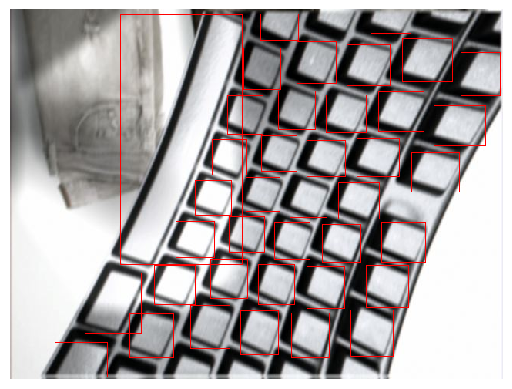

In [3]:
img.extract_rects()
img.show_rects()

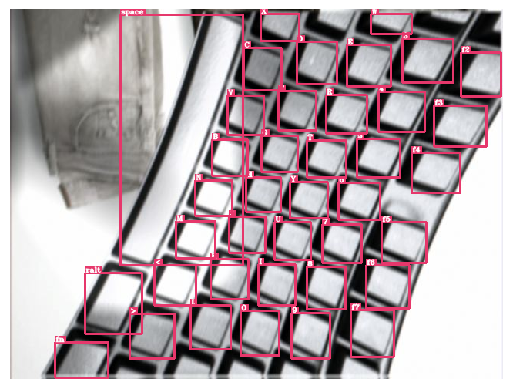

In [4]:
img.extract_keys()
img.show_keys()